<a href="https://colab.research.google.com/github/adrianoaandrade/adrianoaandrade/blob/main/IHBR_DATA_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

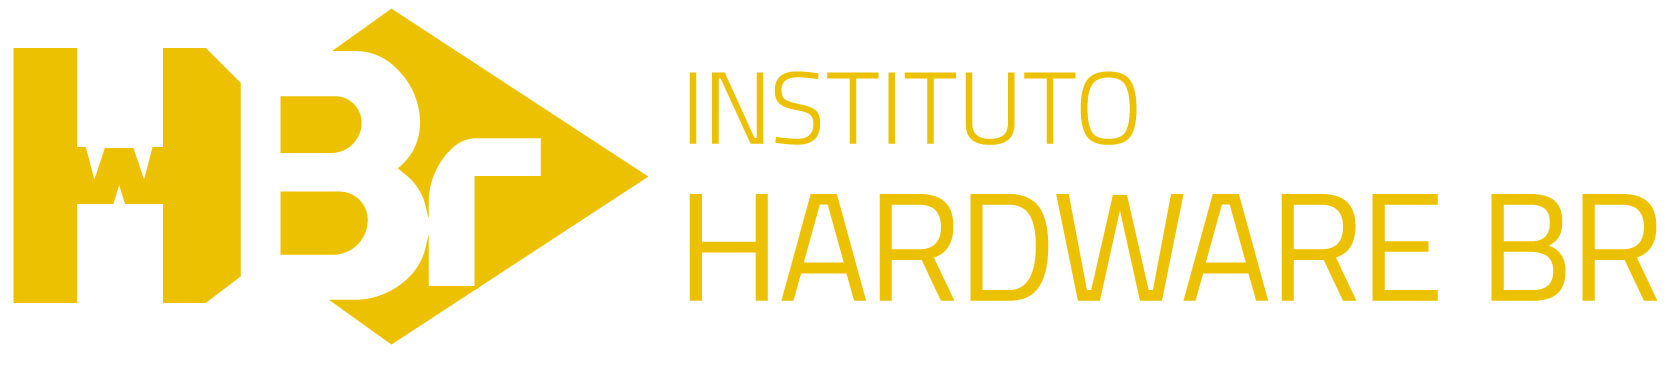

# **Este programa analisa os dados (dataset) de softwares de equipamentos da NASA.**

# **Os datasets disponíveis são relativos aos softwares de diversos equipamentos da NASA, cada um com características e funções distintas.**
# **Esses softwares apresentam uma nomenclatura própria para cada falha.**
# **A análise efetuada pelo programa "IHBR Data Analysis" é feita individualmente para cada software em relação as falhas por eles apresentados.**

##             **Lista dos softwares e suas respecitivas utilizações**

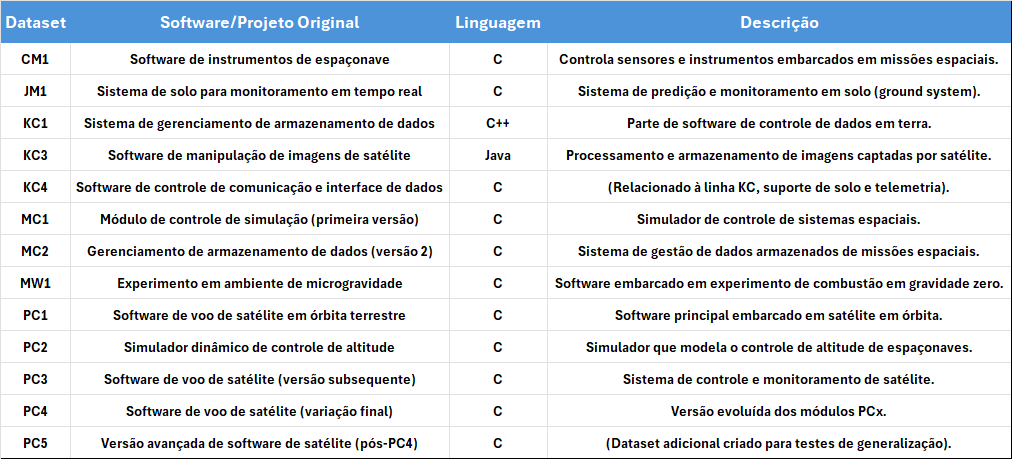

## **Lista das falhas denominadas pela NASA**

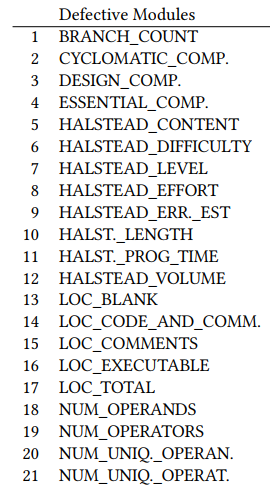

## **Instruções para uso do programa "IHBR Data Analysis"**
## **1. Executar o programa**
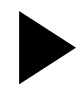
## **2. Escolher o dataset a ser analisado - Opções de 0 a 13!**
## **3. O programa irá baixar os dados do daset da NASA disponível**
##**no github: https://github.com/klainfo/NASADefectDataset/tree/master**
##**gerando o arquivo: < NASA_MDP_repo >**
##**4. O dataset escolhido será analisado e serão geradas imagens gráficas em png**
##**5. Um arquivo .csv e um relatório em pdf consolida os dados e análises do dataset  <NASA_MDP_("dataset_escolhido")_Report.pdf**
## **(clicar na pasta do lado esquerdo do menu do Colab)**


##**Atenção: O Dataset "JM1" está com os dados insuficientes para classificação, inviabilizando a análise!**

## **IHBR Data Analysis Program**

---



In [1]:
# @title IHBR DATA ANALYSIS
# @title

"""
============================================================================
"IHBR Data Analysis Program"
Programa para artigo do curso de Residência em Tecnologias Aeroespaciais -
Inteligência Artificial do Instituto Hardware BR
Autor: Adriano Alves de Andrade - Data:02/11/2025
============================================================================
"""
# Instalação de dependências

%pip install liac-arff reportlab matplotlib seaborn scikit-learn scipy pandas numpy
from IPython.display import clear_output

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import zipfile
import urllib.request
import arff
from datetime import datetime
from scipy.stats import weibull_min
from scipy.special import gamma
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)

# ReportLab imports
from reportlab.lib.pagesizes import A4
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.lib import colors
from reportlab.platypus import (
    SimpleDocTemplate, Paragraph, Spacer, PageBreak, Image,
    Table, TableStyle, KeepTogether
)
from reportlab.lib.enums import TA_CENTER, TA_JUSTIFY, TA_LEFT

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

def download_nasa_dataset(dataset_name='CM1'):
    """Download NASA MDP dataset from GitHub repository"""
    print(f"\n{'='*60}")
    print(f"📦 Baixando dataset {dataset_name} do repositório NASA...")
    print('='*60)

    repo_url = "https://github.com/klainfo/NASADefectDataset/archive/refs/heads/master.zip"

    try:
        response = urllib.request.urlopen(repo_url)
        z = zipfile.ZipFile(io.BytesIO(response.read()))
        z.extractall("NASA_MDP_repo")

        dataset_path = os.path.join(
            "NASA_MDP_repo",
            "NASADefectDataset-master",
            "OriginalData",
            "MDP",
            f"{dataset_name}.arff"
        )

        print(f"✅ Dataset baixado: {dataset_path}")
        return dataset_path
    except Exception as e:
        print(f"❌ Erro ao baixar dataset: {e}")
        return None

def load_and_preprocess_arff(dataset_path):
    """Load and preprocess ARFF file"""
    print("\n📊 Processando arquivo ARFF...")
    print("\n")
    with open(dataset_path, "r", encoding="utf-8", errors="ignore") as f:
        data_arff = arff.load(f)

    df = pd.DataFrame(
        data_arff["data"],
        columns=[a[0] for a in data_arff["attributes"]]
    )

    # Handle byte strings
    df = df.applymap(lambda x: x.decode("utf-8") if isinstance(x, bytes) else x)

    # Clean missing values
    df.replace(["?", "", "NaN", "nan"], np.nan, inplace=True)
    df = df.apply(pd.to_numeric, errors="ignore").dropna()

    # Convert defects to binary
    if "Defective" in df.columns:
        df["defects"] = df["Defective"].apply(
            lambda x: 1 if x in ["Y", "y", 1, "1", "true", "True"] else 0
        )
    elif "defects" in df.columns:
        df["defects"] = df["defects"].apply(
            lambda x: 1 if x in ["Y", "y", 1, "1", "true", "True"] else 0
        )

    # Standardize column names
    column_mapping = {
        'LOC_TOTAL': 'loc',
        'CYCLOMATIC_COMPLEXITY': 'cyclomaticComplexity',
        'v(g)': 'cyclomaticComplexity',
        'ESSENTIAL_COMPLEXITY': 'essentialComplexity',
        'ev(g)': 'essentialComplexity',
        'DESIGN_COMPLEXITY': 'designComplexity',
        'iv(g)': 'designComplexity',
        'BRANCH_COUNT': 'branchCount'
    }

    df.rename(columns=column_mapping, inplace=True)

    # Calculate defect density
    if 'loc' in df.columns:
        df['defectDensity'] = (df['defects'] / (df['loc'] / 1000)).replace([np.inf, -np.inf], 0)

    # Add module names if not present
    if 'module' not in df.columns:
        df['module'] = [f"Module_{str(i).zfill(3)}" for i in range(len(df))]
    print("\n")
    print(f"✅ Dataset processado: {len(df)} módulos carregados")
    return df

def calculate_basic_statistics(df):
    """Calculate and return basic statistics"""
    total = len(df)
    defective = df['defects'].sum()
    defect_rate = (defective / total) * 100

    stats = {
        'total': total,
        'defective': defective,
        'defect_rate': defect_rate,
        'non_defective': total - defective,
        'non_defect_rate': 100 - defect_rate
    }

    if 'cyclomaticComplexity' in df.columns:
        stats['cyclo_mean'] = df['cyclomaticComplexity'].mean()
        stats['cyclo_max'] = df['cyclomaticComplexity'].max()

    if 'essentialComplexity' in df.columns:
        stats['essential_mean'] = df['essentialComplexity'].mean()

    if 'designComplexity' in df.columns:
        stats['design_mean'] = df['designComplexity'].mean()

    if 'loc' in df.columns:
        stats['loc_mean'] = df['loc'].mean()
        stats['loc_total'] = df['loc'].sum()

    if 'defectDensity' in df.columns:
        stats['defect_density_mean'] = df['defectDensity'].mean()

    return stats

def calculate_weibull_metrics(df):
    """Calculate Weibull distribution parameters and reliability metrics"""
    if 'loc' not in df.columns:
        return None

    tempo = df['loc'].astype(float).values
    tempo = tempo[tempo > 0]

    if len(tempo) == 0:
        return None

    # Fit Weibull distribution
    shape, _, scale = weibull_min.fit(tempo, floc=0)

    # Calculate reliability metrics
    MTTF = scale * gamma(1 + 1/shape)
    MTBF = MTTF / (1 - np.exp(-1))
    MTTR = MTTF * 0.05
    availability = (MTBF / (MTBF + MTTR)) * 100
    failure_rate = 1 / MTTF

    return {
        'shape': shape,
        'scale': scale,
        'tempo': tempo,
        'MTTF': MTTF,
        'MTBF': MTBF,
        'MTTR': MTTR,
        'availability': availability,
        'failure_rate': failure_rate
    }

def calculate_inverse_power_law(df):
    """Calculate Inverse Power Law parameters"""
    if 'branchCount' not in df.columns:
        return None

    stress = df['branchCount'].astype(float)
    stress = stress[stress > 0]

    if len(stress) < 2:
        return None

    max_stress = stress.max()
    vida = 1 / (np.power(stress / max_stress, 0.8) + 1e-5)
    vida = vida / vida.max()

    log_stress = np.log(stress + 1e-3)
    log_vida = np.log(vida + 1e-3)

    coef = np.polyfit(log_stress, log_vida, 1)
    n = -coef[0]
    K = np.exp(coef[1])

    return {'n': n, 'K': K}

def analyze_correlation(df):
    """Analyze correlation between variables and defects"""
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if 'defects' not in numeric_cols:
        return None

    correlations = df[numeric_cols].corr()['defects'].sort_values(ascending=False)
    return correlations

def train_and_evaluate_models(df):
    """Train multiple ML models and evaluate performance"""
    feature_cols = ['loc', 'cyclomaticComplexity', 'essentialComplexity', 'designComplexity']
    available_features = [col for col in feature_cols if col in df.columns]

    if len(available_features) == 0:
        return None, None

    X = df[available_features]
    y = df['defects']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    models = {
        'Logistic Regression': LogisticRegression(solver='liblinear', max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
    }

    results = {}
    best_model = None
    best_score = 0

    for name, model in models.items():
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        cv_scores = cross_val_score(model, X, y, cv=5)

        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'cv_score': cv_scores.mean(),
            'y_test': y_test,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }

        if roc_auc > best_score:
            best_score = roc_auc
            best_model = name

    # Add predictions to dataframe
    best_model_obj = results[best_model]['model']
    df['predictedProbabilityOfDefect'] = best_model_obj.predict_proba(X)[:, 1]
    df['predictedDefect'] = best_model_obj.predict(X)

    def risk_level(prob):
        if prob >= 0.7:
            return "Alto"
        elif prob >= 0.4:
            return "Médio"
        else:
            return "Baixo"

    df['riskLevel'] = df['predictedProbabilityOfDefect'].apply(risk_level)

    return results, best_model

def generate_all_plots(df, weibull_data, ipl_data, results, best_model, correlations, dataset_name='CM1'):
    """Generate and save all plots for PDF"""
    plot_files = []

    # 1. Top 5 Correlations
    if correlations is not None:
        top_5_corr = correlations[correlations.index != 'defects'].abs().nlargest(5)
        fig, ax = plt.subplots(figsize=(10, 6))
        top_5_corr.plot(kind='barh', ax=ax, color='steelblue')
        ax.set_xlabel('Correlação Absoluta com Defeitos')
        ax.set_title('Top 5 Métricas com Maior Correlação Absoluta com Defeitos', fontweight='bold')
        ax.grid(True, alpha=0.3)
        filename = f'{dataset_name}_top5_correlations.png'
        plt.tight_layout()
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        plt.close()
        plot_files.append(filename)

    # 2. Comparison Metrics (Boxplots)
    metrics_to_compare = ['loc', 'cyclomaticComplexity', 'defectDensity']
    present_metrics = [m for m in metrics_to_compare if m in df.columns]

    if present_metrics and 'defects' in df.columns:
        fig, axes = plt.subplots(1, len(present_metrics), figsize=(6 * len(present_metrics), 6))
        if len(present_metrics) == 1:
            axes = [axes]

        for i, metric in enumerate(present_metrics):
            sns.boxplot(x='defects', y=metric, data=df, ax=axes[i])
            axes[i].set_title(f'Distribuição de {metric}')
            axes[i].set_xlabel('Defeito')
            axes[i].set_xticklabels(['Sem Defeito', 'Com Defeito'])

        filename = f'{dataset_name}_comparison_metrics.png'
        plt.tight_layout()
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        plt.close()
        plot_files.append(filename)

    # 3. Weibull Distribution
    if weibull_data:
        fig, ax = plt.subplots(figsize=(10, 6))
        tempo = weibull_data['tempo']
        shape = weibull_data['shape']
        scale = weibull_data['scale']
        t = np.linspace(min(tempo), max(tempo), 200)

        sns.histplot(tempo, bins=30, stat="density", color="lightblue", ax=ax)
        ax.plot(t, weibull_min.pdf(t, shape, 0, scale), "r-", lw=2, label='Weibull Fit')
        ax.set_title(f"Distribuição Weibull (β={shape:.2f}, η={scale:.2f})", fontweight='bold')
        ax.set_xlabel("LOC")
        ax.set_ylabel("Densidade")
        ax.legend()
        ax.grid(True, alpha=0.3)
        filename = f'{dataset_name}_weibull.png'
        plt.tight_layout()
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        plt.close()
        plot_files.append(filename)

    # 4. Inverse Power Law
    if ipl_data and 'n' in ipl_data and 'K' in ipl_data and 'branchCount' in df.columns:
        n = ipl_data['n']
        K = ipl_data['K']

        stress_values = df['branchCount'].astype(float).values
        stress_values = stress_values[stress_values > 0]

        if len(stress_values) > 1:
            min_stress = np.min(stress_values)
            max_stress = np.max(stress_values)
            plot_stress = np.linspace(min_stress, max_stress, 100)

            if max_stress > 0:
                plot_life = K * (plot_stress / max_stress)**(-n)
            else:
                plot_life = np.zeros_like(plot_stress)

            fig, ax = plt.subplots(figsize=(10, 6))
            sns.scatterplot(x=stress_values, y=(K * (stress_values / max_stress)**(-n)), label='Observed Data (Fitted)', color='blue', alpha=0.6, ax=ax)
            ax.plot(plot_stress, plot_life, color='red', linestyle='--', label=f'Inverse Power Law Fit (n={n:.2f}, K={K:.2f})')
            ax.set_title('Lei de Potência Inversa: Estresse vs. Vida', fontsize=16, fontweight='bold')
            ax.set_xlabel('Estresse (Branch Count)', fontsize=12)
            ax.set_ylabel('Vida Relativa (Proporcional a 1/Failure Rate)', fontsize=12)
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.legend()
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)
            filename = f'{dataset_name}_inverse_power_law.png'
            plt.tight_layout()
            plt.savefig(filename, dpi=150, bbox_inches='tight')
            plt.close()
            plot_files.append(filename)

    # 5. Complexity vs Predicted Probability of Defect
    required_cols = [
        'cyclomaticComplexity',
        'predictedProbabilityOfDefect',
        'riskLevel',
        'loc'
    ]

    if all(col in df.columns for col in required_cols):

        fig, ax = plt.subplots(figsize=(12, 8))

        # Order of risk labels
        risk_order = ['Baixo', 'Médio', 'Alto']

        scatter = sns.scatterplot(
            x='cyclomaticComplexity',
            y='predictedProbabilityOfDefect',
            hue='riskLevel',
            size='loc',
            sizes=(50, 1000),
            hue_order=risk_order,
            palette={'Baixo': 'green', 'Médio': 'orange', 'Alto': 'red'},
            alpha=0.6,
            data=df,
            ax=ax
        )

        ax.set_title('Complexidade Ciclomática vs. Probabilidade de Defeito',
                     fontsize=16, fontweight='bold')
        ax.set_xlabel('Complexidade Ciclomática', fontsize=12)
        ax.set_ylabel('Probabilidade Predita de Defeito', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)

        # Clean legend removing “size” numerical markers
        handles, labels = ax.get_legend_handles_labels()
        new_handles = []
        new_labels = []
        for h, l in zip(handles, labels):
            if l.replace('.', '', 1).isdigit():
                continue
            new_handles.append(h)
            new_labels.append(l)

        ax.legend(new_handles, new_labels, title='Nível de Risco',
                  loc='upper left', bbox_to_anchor=(1, 1))

        plt.tight_layout()

        filename = f"{dataset_name}_complexity_vs_defect_probability.png"
        plt.savefig(filename, dpi=150)
        plt.close()

        plot_files.append(filename)


    # 6. Correlation Heatmap
    corr_cols = ['loc', 'cyclomaticComplexity', 'essentialComplexity', 'designComplexity', 'defects']
    present_cols = [col for col in corr_cols if col in df.columns]
    if len(present_cols) >= 2:
        fig, ax = plt.subplots(figsize=(10, 8))
        corr_matrix = df[present_cols].corr()
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn_r',
                    center=0, square=True, ax=ax, cbar_kws={'label': 'Correlação'})
        ax.set_title("Matriz de Correlação", fontweight='bold')
        filename = f'{dataset_name}_correlation_heatmap.png'
        plt.tight_layout()
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        plt.close()
        plot_files.append(filename)

    # 7-9. ROC Curves
    if results:
        for name, result in results.items():
            fig, ax = plt.subplots(figsize=(8, 6))
            fpr, tpr, _ = roc_curve(result['y_test'], result['y_pred_proba'])
            roc_auc = result['roc_auc']

            ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
            ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            ax.set_xlabel("Taxa de Falsos Positivos")
            ax.set_ylabel("Taxa de Verdadeiros Positivos")
            ax.set_title(f"Curva ROC - {name}", fontweight='bold')
            ax.legend(loc="lower right")
            ax.grid(True, alpha=0.3)
            filename = f'{dataset_name}_roc_{name.replace(" ", "_")}.png'
            plt.tight_layout()
            plt.savefig(filename, dpi=150, bbox_inches='tight')
            plt.close()
            plot_files.append(filename)

    # 10-12. Confusion Matrices
    if results:
        for name, result in results.items():
            fig, ax = plt.subplots(figsize=(8, 6))
            cm = result['confusion_matrix']
            disp = ConfusionMatrixDisplay(
                confusion_matrix=cm,
                display_labels=['Sem Defeito', 'Com Defeito']
            )
            disp.plot(cmap=plt.cm.Blues, ax=ax)
            ax.set_title(f"Matriz de Confusão - {name}", fontweight='bold')
            filename = f'{dataset_name}_cm_{name.replace(" ", "_")}.png'
            plt.tight_layout()
            plt.savefig(filename, dpi=150, bbox_inches='tight')
            plt.close()
            plot_files.append(filename)

    # 13. Model Performance Comparison
    if results:
        fig, ax = plt.subplots(figsize=(12, 6))
        metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
        model_names = list(results.keys())
        x = np.arange(len(model_names))
        width = 0.15

        for i, metric in enumerate(metrics):
            values = [results[model][metric] for model in model_names]
            ax.bar(x + i*width, values, width, label=metric.upper())

        ax.set_xlabel("Modelo")
        ax.set_ylabel("Pontuação")
        ax.set_title("Comparação de Performance dos Modelos", fontweight='bold')
        ax.set_xticks(x + width * 2)
        ax.set_xticklabels(model_names, rotation=15, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        filename = f'{dataset_name}_model_comparison.png'
        plt.tight_layout()
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        plt.close()
        plot_files.append(filename)

    # 14. Risk Level Distribution
    if 'riskLevel' in df.columns:
        fig, ax = plt.subplots(figsize=(10, 6))
        risk_counts = df['riskLevel'].value_counts()
        colors_risk = {'Alto': '#dc2626', 'Médio': '#f59e0b', 'Baixo': '#16a34a'}
        ax.bar(risk_counts.index, risk_counts.values,
               color=[colors_risk.get(x, 'gray') for x in risk_counts.index])
        ax.set_xlabel("Nível de Risco")
        ax.set_ylabel("Número de Módulos")
        ax.set_title("Distribuição de Níveis de Risco", fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        filename = f'{dataset_name}_risk_distribution.png'
        plt.tight_layout()
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        plt.close()
        plot_files.append(filename)

    return plot_files

def generate_pdf_report(df, stats, weibull_data, ipl_data, correlations, results, best_model,
                       plot_files, dataset_name='CM1', dataset_path=''):
    """Generate comprehensive PDF report"""

    pdf_filename = f'IHBR_DATA_ANALYSIS_{dataset_name}_Report.pdf'
    doc = SimpleDocTemplate(pdf_filename, pagesize=A4,
                          rightMargin=72, leftMargin=72,
                          topMargin=72, bottomMargin=18)

    # Container for PDF elements
    story = []

    # Styles
    styles = getSampleStyleSheet()
    title_style = ParagraphStyle(
        'CustomTitle',
        parent=styles['Heading1'],
        fontSize=24,
        textColor=colors.HexColor('#1e40af'),
        spaceAfter=30,
        alignment=TA_CENTER,
        fontName='Helvetica-Bold'
    )

    heading1_style = ParagraphStyle(
        'CustomHeading1',
        parent=styles['Heading1'],
        fontSize=16,
        textColor=colors.HexColor('#1e40af'),
        spaceAfter=12,
        spaceBefore=12,
        fontName='Helvetica-Bold'
    )

    heading2_style = ParagraphStyle(
        'CustomHeading2',
        parent=styles['Heading2'],
        fontSize=14,
        textColor=colors.HexColor('#3b82f6'),
        spaceAfter=10,
        spaceBefore=10,
        fontName='Helvetica-Bold'
    )

    normal_style = ParagraphStyle(
        'CustomNormal',
        parent=styles['Normal'],
        fontSize=10,
        alignment=TA_JUSTIFY,
        spaceAfter=6
    )

    # Title Page
    story.append(Spacer(1, 2*inch))
    story.append(Paragraph("IHBR DATA ANALYSIS", title_style))
    story.append(Spacer(1, 0.3*inch))

    story.append(Paragraph(f"Análise Unificada com Weibull, ML e Correlações",
                          ParagraphStyle('subtitle', parent=normal_style, fontSize=14,
                                       alignment=TA_CENTER, textColor=colors.HexColor('#64748b'))))

    story.append(Paragraph(f"Autor: Adriano Alves de Andrade",
                          ParagraphStyle('subtitle', parent=normal_style, fontSize=14,
                                       alignment=TA_CENTER, textColor=colors.HexColor('#64748b'))))

    story.append(Spacer(1, 0.5*inch))
    story.append(Paragraph(f"<b>Dataset:</b> {dataset_name}",
                          ParagraphStyle('info', parent=normal_style, fontSize=12, alignment=TA_CENTER)))
    story.append(Paragraph(f"<b>Data:</b> {datetime.now().strftime('%d/%m/%Y %H:%M')}",
                          ParagraphStyle('info', parent=normal_style, fontSize=12, alignment=TA_CENTER)))
    story.append(Spacer(1, 0.3*inch))
    story.append(Paragraph(f"<b>Dataset baixado:</b><br/>{dataset_path}",
                          ParagraphStyle('path', parent=normal_style, fontSize=9, alignment=TA_CENTER)))

    story.append(PageBreak())

    # ====================
    # ESTATÍSTICAS DESCRITIVAS
    # ====================
    story.append(Paragraph("ESTATÍSTICAS DESCRITIVAS", heading1_style))
    story.append(Spacer(1, 0.2*inch))

    stats_text = f"""
    <b>Total de Módulos:</b> {stats['total']}<br/>
    <b>Módulos com Defeitos:</b> {stats['defective']} ({stats['defect_rate']:.2f}%)<br/>
    <b>Módulos sem Defeitos:</b> {stats['non_defective']} ({stats['non_defect_rate']:.2f}%)<br/><br/>

    <b>--- Métricas de Complexidade ---</b><br/>
    """

    if 'cyclo_mean' in stats:
        stats_text += f"<b>Complexidade Ciclomática Média:</b> {stats['cyclo_mean']:.2f}<br/>"
        stats_text += f"<b>Complexidade Ciclomática Máxima:</b> {stats['cyclo_max']:.0f}<br/>"

    if 'essential_mean' in stats:
        stats_text += f"<b>Complexidade Essencial Média:</b> {stats['essential_mean']:.2f}<br/>"

    if 'design_mean' in stats:
        stats_text += f"<b>Complexidade de Design Média:</b> {stats['design_mean']:.2f}<br/>"

    stats_text += "<br/><b>--- Métricas de Código ---</b><br/>"

    if 'loc_mean' in stats:
        stats_text += f"<b>LOC Média:</b> {stats['loc_mean']:.2f}<br/>"
        stats_text += f"<b>LOC Total:</b> {stats['loc_total']:.0f}<br/>"

    if 'defectDensity' in stats:
        stats_text += f"<b>Densidade de Defeitos Média:</b> {stats['defectDensity_mean']:.2f} defeitos/KLOC<br/>"

    story.append(Paragraph(stats_text, normal_style))
    story.append(Spacer(1, 0.3*inch))

    # ====================
    # ANÁLISE WEIBULL
    # ====================
    story.append(Paragraph("ANÁLISE WEIBULL E MÉTRICAS DE CONFIABILIDADE", heading1_style))
    story.append(Spacer(1, 0.2*inch))

    if weibull_data:
        weibull_text = f"""
        <b>Parâmetros Weibull:</b><br/>
        • β (shape): {weibull_data['shape']:.4f}<br/>
        • η (scale): {weibull_data['scale']:.4f}<br/><br/>

        <b>Métricas de Confiabilidade:</b><br/>
        • MTTF (Mean Time To Failure): {weibull_data['MTTF']:.2f} horas<br/>
        • MTBF (Mean Time Between Failures): {weibull_data['MTBF']:.2f} horas<br/>
        • MTTR (Mean Time To Repair): {weibull_data['MTTR']:.2f} horas<br/>
        • Disponibilidade: {weibull_data['availability']:.2f}%<br/>
        • Taxa de Falha: {weibull_data['failure_rate']:.5f} falhas/hora
        """
        story.append(Paragraph(weibull_text, normal_style))
    else:
        story.append(Paragraph("⚠️ Dados insuficientes para análise Weibull", normal_style))

    story.append(Spacer(1, 0.3*inch))

    # ====================
    # ANÁLISE DE POTÊNCIA INVERSA
    # ====================
    story.append(Paragraph("ANÁLISE DE POTÊNCIA INVERSA", heading1_style))
    story.append(Spacer(1, 0.2*inch))

    if ipl_data:
        ipl_text = f"""
        <b>Parâmetros de Potência Inversa:</b><br/>
        • n (expoente): {ipl_data['n']:.4f}<br/>
        • K (constante): {ipl_data['K']:.4f}
        """
        story.append(Paragraph(ipl_text, normal_style))
    else:
        story.append(Paragraph("⚠️ Dados insuficientes para análise de Potência Inversa", normal_style))

    story.append(PageBreak())

    # ====================
    # ANÁLISE DE CORRELAÇÃO (Tabela)
    # ====================
    story.append(Paragraph("ANÁLISE DE CORRELAÇÃO", heading1_style))
    story.append(Spacer(1, 0.2*inch))

    if correlations is not None:
        corr_data = [['Variável', 'Correlação com Defeitos']]
        for col, corr in correlations.items():
            if col != 'defects':
                corr_data.append([col, f"{corr:.4f}"])

        corr_table = Table(corr_data, colWidths=[3.5*inch, 2*inch])
        corr_table.setStyle(TableStyle([
            ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#3b82f6')),
            ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
            ('ALIGN', (0, 0), (-1, -1), 'LEFT'),
            ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
            ('FONTSIZE', (0, 0), (-1, 0), 12),
            ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
            ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
            ('GRID', (0, 0), (-1, -1), 1, colors.black),
            ('FONTSIZE', (0, 1), (-1, -1), 10),
            ('ROWBACKGROUNDS', (0, 1), (-1, -1), [colors.white, colors.lightgrey]),
        ]))
        story.append(corr_table)

    story.append(Spacer(1, 0.3*inch))

    # ====================
    # TREINAMENTO E AVALIAÇÃO DE MODELOS ML
    # ====================
    story.append(Paragraph("TREINAMENTO E AVALIAÇÃO DE MODELOS ML", heading1_style))
    story.append(Spacer(1, 0.1*inch))

    if results and best_model:
        # Best model banner
        best_score = results[best_model]['roc_auc']
        story.append(Paragraph(f"🏆 <b>Melhor Modelo:</b> {best_model} (ROC AUC: {best_score:.4f})",
                              ParagraphStyle('best', parent=normal_style, fontSize=12,
                                           textColor=colors.HexColor('#16a34a'),
                                           spaceAfter=12, fontName='Helvetica-Bold')))

        # Models table
        ml_data = [['Modelo', 'Acurácia', 'Precisão', 'Revocação', 'F1-Score', 'ROC AUC', 'CV Score']]
        for name, result in results.items():
            ml_data.append([
                name,
                f"{result['accuracy']:.4f}",
                f"{result['precision']:.4f}",
                f"{result['recall']:.4f}",
                f"{result['f1']:.4f}",
                f"{result['roc_auc']:.4f}",
                f"{result['cv_score']:.4f}"
            ])

        ml_table = Table(ml_data, colWidths=[1.5*inch, 0.8*inch, 0.8*inch, 0.8*inch, 0.8*inch, 0.8*inch, 0.8*inch])
        ml_table.setStyle(TableStyle([
            ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#3b82f6')),
            ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
            ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
            ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
            ('FONTSIZE', (0, 0), (-1, 0), 10),
            ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
            ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
            ('GRID', (0, 0), (-1, -1), 1, colors.black),
            ('FONTSIZE', (0, 1), (-1, -1), 9),
            ('ROWBACKGROUNDS', (0, 1), (-1, -1), [colors.white, colors.lightgrey]),
        ]))
        story.append(ml_table)

    story.append(PageBreak())

    # ====================
    # ANÁLISE DETALHADA POR MÓDULO
    # ====================
    story.append(Paragraph("ANÁLISE DETALHADA POR MÓDULO", heading1_style))
    story.append(Spacer(1, 0.2*inch))

    if 'predictedProbabilityOfDefect' in df.columns:
        high_risk_df = df[
            (df['defects'] == 1) |
            (df['predictedProbabilityOfDefect'] > 0.5)
        ].copy()

        if len(high_risk_df) > 0:
            story.append(Paragraph(f"<b>{len(high_risk_df)} módulos com defeitos ou alto risco</b>", normal_style))
            story.append(Spacer(1, 0.1*inch))

            module_data = [['Módulo', 'LOC', 'Compl.', 'Defeitos', 'Dens.', 'Prob.(%)', 'Risco']]
            for _, row in high_risk_df.head(20).iterrows():
                prob = row.get('predictedProbabilityOfDefect', 0) * 100
                risk = row.get('riskLevel', 'N/A')

                module_data.append([
                    row['module'][:12],
                    f"{int(row.get('loc', 0))}",
                    f"{int(row.get('cyclomaticComplexity', 0))}",
                    f"{int(row['defects'])}",
                    f"{row.get('defectDensity', 0):.2f}",
                    f"{prob:.1f}",
                    risk
                ])

            module_table = Table(module_data, colWidths=[1.2*inch, 0.6*inch, 0.7*inch, 0.7*inch, 0.7*inch, 0.8*inch, 0.8*inch])
            module_table.setStyle(TableStyle([
                ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#dc2626')),
                ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
                ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                ('FONTSIZE', (0, 0), (-1, 0), 9),
                ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
                ('GRID', (0, 0), (-1, -1), 1, colors.black),
                ('FONTSIZE', (0, 1), (-1, -1), 8),
                ('ROWBACKGROUNDS', (0, 1), (-1, -1), [colors.white, colors.lightgrey]),
            ]))
            story.append(module_table)
        else:
            story.append(Paragraph("✅ Nenhum módulo de alto risco encontrado!", normal_style))

    story.append(PageBreak())

    # ====================
    # RESUMO DAS PRINCIPAIS ESTATÍSTICAS
    # ====================
    story.append(Paragraph("RESUMO DAS PRINCIPAIS ESTATÍSTICAS", heading1_style))
    story.append(Spacer(1, 0.2*inch))

    summary_text = f"""
    <b>Análise Geral do Dataset {dataset_name}:</b><br/><br/>

    O dataset contém <b>{stats['total']} módulos</b>, dos quais <b>{stats['defective']} ({stats['defect_rate']:.2f}%)</b>
    apresentam defeitos. A taxa de defeitos observada fornece uma base importante para avaliar a qualidade do software.<br/><br/>

    <b>Complexidade do Código:</b><br/>
    """

    if 'cyclo_mean' in stats:
        summary_text += f"<b>Complexidade Ciclomática Média:</b> {stats['cyclo_mean']:.2f}<br/>"
        summary_text += f"<b>Complexidade Ciclomática Máxima:</b> {stats['cyclo_max']:.0f}<br/>"

    if 'essential_mean' in stats:
        summary_text += f"<b>Complexidade Essencial Média:</b> {stats['essential_mean']:.2f}<br/>"

    if 'design_mean' in stats:
        summary_text += f"<b>Complexidade de Design Média:</b> {stats['design_mean']:.2f}<br/>"

    if weibull_data:
        summary_text += f"""
        <b>Confiabilidade do Sistema:</b><br/>
        O sistema apresenta MTTF de <b>{weibull_data['MTTF']:.2f} horas</b> e disponibilidade de <b>{weibull_data['availability']:.2f}%</b>.
        O parâmetro β de Weibull ({weibull_data['shape']:.2f}) indica """

        if weibull_data['shape'] < 1:
            summary_text += "taxa de falha decrescente (mortalidade infantil)."
        elif weibull_data['shape'] > 1:
            summary_text += "taxa de falha crescente (desgaste/envelhecimento)."
        else:
            summary_text += "taxa de falha constante (vida útil)."

        summary_text += "<br/><br/>"

    story.append(Paragraph(summary_text, normal_style))

    story.append(PageBreak())

    # ====================
    # ANÁLISE E INTERPRETAÇÃO DOS RESULTADOS DOS MODELOS ML
    # ====================
    story.append(Paragraph("ANÁLISE E INTERPRETAÇÃO DOS RESULTADOS DOS MODELOS ML", heading1_style))
    story.append(Spacer(1, 0.2*inch))

    if results:
        ml_analysis = f"""
        <b>Performance dos Modelos:</b><br/><br/>

        Três modelos de aprendizado de máquina foram treinados e avaliados para predição de defeitos:<br/><br/>
        """

        for name, result in results.items():
            ml_analysis += f"""
            <b>{name}:</b><br/>
            • Acurácia: {result['accuracy']:.4f} - Proporção de predições corretas<br/>
            • Precisão: {result['precision']:.4f} - Dos módulos preditos como defeituosos, quantos realmente são<br/>
            • Revocação: {result['recall']:.4f} - Dos módulos defeituosos, quantos foram identificados<br/>
            • F1-Score: {result['f1']:.4f} - Média harmônica entre precisão e revocação<br/>
            • ROC AUC: {result['roc_auc']:.4f} - Capacidade de discriminação do modelo<br/>
            • Cross-Validation: {result['cv_score']:.4f} - Performance em diferentes subconjuntos<br/><br/>
            """

        ml_analysis += f"""
        <b>Melhor Modelo Selecionado:</b><br/>
        O modelo <b>{best_model}</b> foi selecionado com base no maior ROC AUC ({results[best_model]['roc_auc']:.4f}),
        indicando superior capacidade de distinção entre módulos com e sem defeitos.<br/><br/>
        """

        story.append(Paragraph(ml_analysis, normal_style))

    story.append(Spacer(1, 0.2*inch))

    # ====================
    # Interpretação das Matrizes de Confusão
    # ====================
    story.append(Paragraph("Interpretação das Métricas e Matrizes de Confusão", heading2_style))
    story.append(Spacer(1, 0.1*inch))

    if results and best_model:
        cm = results[best_model]['confusion_matrix']
        tn, fp, fn, tp = cm.ravel()

        cm_text = f"""
        <b>Matriz de Confusão do Melhor Modelo ({best_model}):</b><br/><br/>

        • <b>Verdadeiros Negativos (TN):</b> {tn} - Módulos sem defeito corretamente identificados<br/>
        • <b>Falsos Positivos (FP):</b> {fp} - Módulos sem defeito incorretamente identificados como defeituosos<br/>
        • <b>Falsos Negativos (FN):</b> {fn} - Módulos defeituosos não identificados (⚠️ risco crítico)<br/>
        • <b>Verdadeiros Positivos (TP):</b> {tp} - Módulos defeituosos corretamente identificados<br/><br/>

        <b>Análise de Risco:</b><br/>
        Os falsos negativos ({fn}) representam o maior risco, pois são defeitos que passariam despercebidos.
        Os falsos positivos ({fp}) geram retrabalho, mas são preferíveis a não detectar defeitos reais.<br/>
        """

        story.append(Paragraph(cm_text, normal_style))

    story.append(PageBreak())

    # ====================
    # INTERPRETANDO OS PARÂMETROS DE CONFIABILIDADE
    # ====================
    story.append(Paragraph("INTERPRETANDO OS PARÂMETROS DE CONFIABILIDADE", heading1_style))
    story.append(Spacer(1, 0.2*inch))

    if weibull_data:
        reliability_text = f"""
        <b>Distribuição de Weibull:</b><br/>
        A distribuição de Weibull é amplamente utilizada em análise de confiabilidade para modelar tempo até falha.<br/><br/>

        <b>Parâmetro β (Shape = {weibull_data['shape']:.4f}):</b><br/>
        """

        if weibull_data['shape'] < 1:
            reliability_text += """
            • β &lt; 1: Taxa de falha <b>decrescente</b> ao longo do tempo<br/>
            • Indica período de "mortalidade infantil" - defeitos iniciais sendo eliminados<br/>
            • Comum em software novo com bugs sendo corrigidos rapidamente<br/><br/>
            """
        elif weibull_data['shape'] > 1:
            reliability_text += """
            • β &gt; 1: Taxa de falha <b>crescente</b> ao longo do tempo<br/>
            • Indica "envelhecimento" ou desgaste do sistema<br/>
            • Software acumulando problemas de manutenção ou dívida técnica<br/><br/>
            """
        else:
            reliability_text += """
            • β ≈ 1: Taxa de falha <b>constante</b><br/>
            • Indica período de vida útil estável<br/>
            • Falhas ocorrem de forma aleatória e imprevisível<br/><br/>
            """

        reliability_text += f"""
        <b>Parâmetro η (Scale = {weibull_data['scale']:.4f}):</b><br/>
        • Representa o tempo característico de vida<br/>
        • Aproximadamente 63.2% das falhas ocorrem até este tempo<br/><br/>

        <b>MTTF ({weibull_data['MTTF']:.2f} horas):</b><br/>
        • Tempo médio até a primeira falha<br/>
        • Quanto maior, mais confiável o sistema<br/><br/>

        <b>MTBF ({weibull_data['MTBF']:.2f} horas):</b><br/>
        • Tempo médio entre falhas consecutivas<br/>
        • Métrica chave para sistemas reparáveis<br/><br/>

        <b>MTTR ({weibull_data['MTTR']:.2f} horas):</b><br/>
        • Tempo médio de reparo<br/>
        • Indica eficiência da equipe de manutenção<br/><br/>

        <b>Disponibilidade ({weibull_data['availability']:.2f}%):</b><br/>
        • Proporção do tempo em que o sistema está operacional<br/>
        • Disponibilidade = MTBF / (MTBF + MTTR)<br/>
        • Valor alto indica sistema robusto e fácil de reparar<br/><br/>

        <b>Taxa de Falha ({weibull_data['failure_rate']:.5f} falhas/hora):</b><br/>
        • Frequência esperada de falhas<br/>
        • Valores baixos indicam alta confiabilidade<br/>
        """

        story.append(Paragraph(reliability_text, normal_style))

    story.append(PageBreak())

    # ====================
    # ANÁLISE DAS MÉTRICAS COM MAIOR CORRELAÇÃO
    # ====================
    story.append(Paragraph("ANÁLISE DAS MÉTRICAS COM MAIOR CORRELAÇÃO COM DEFEITOS", heading1_style))
    story.append(Spacer(1, 0.2*inch))

    if correlations is not None:
        top_corr = correlations[correlations.index != 'defects'].abs().nlargest(5)

        corr_analysis = """
        <b>As 5 métricas com maior correlação absoluta com defeitos:</b><br/><br/>
        """

        for i, (metric, corr_val) in enumerate(top_corr.items(), 1):
            actual_corr = correlations[metric]
            direction = "positiva" if actual_corr > 0 else "negativa"
            strength = "forte" if abs(actual_corr) > 0.7 else "moderada" if abs(actual_corr) > 0.4 else "fraca"

            corr_analysis += f"""
            <b>{i}. {metric}</b> (correlação {direction} {strength}: {actual_corr:.4f})<br/>
            """

            if metric == 'cyclomaticComplexity':
                corr_analysis += "   Complexidade ciclomática mede o número de caminhos independentes. Alta complexidade dificulta testes e manutenção.<br/>"
            elif metric == 'loc':
                corr_analysis += "   Linhas de código: módulos maiores tendem a ter mais defeitos simplesmente por terem mais código.<br/>"
            elif metric == 'essentialComplexity': # Corrected line
                corr_analysis += "   Complexidade essencial indica estrutura não estruturada. Valores altos sugerem código difícil de manter.<br/>"
            elif metric == 'designComplexity':
                corr_analysis += "   Complexidade de design mede interações entre módulos. Alta complexidade dificulta compreensão e modificação.<br/>"
            elif metric == 'defectDensity':
                corr_analysis += "   Densidade de defeitos normaliza defeitos por tamanho. Métrica chave para comparar módulos de diferentes tamanhos.<br/>"

            corr_analysis += "<br/>"

        story.append(Paragraph(corr_analysis, normal_style))

    story.append(PageBreak())

    # ====================
    # INTERPRETANDO AS VISUALIZAÇÕES
    # ====================
    story.append(Paragraph("INTERPRETANDO AS VISUALIZAÇÕES", heading1_style))
    story.append(Spacer(1, 0.2*inch))

    viz_text = """
    <b>1. Top 5 Correlações:</b> Identifica quais métricas de código têm maior associação com defeitos.
    Métricas com alta correlação devem ser priorizadas no controle de qualidade.<br/><br/>

    <b>2. Comparação de Métricas (Boxplots):</b> Mostra diferenças nas distribuições de métricas entre módulos
    com e sem defeitos. Permite visualizar rapidamente quais características distinguem código defeituoso.<br/><br/>

    <b>3. Distribuição de Weibull:</b> Ajuste da distribuição de Weibull aos dados de LOC. A qualidade do
    ajuste indica se o modelo de confiabilidade é apropriado para este dataset.<br/><br/>

    <b>4. Lei de Potência Inversa:</b> Scatter plot mostrando a relação entre o estresse (Branch Count) e a vida relativa. O ajuste da curva demonstra como o aumento do estresse impacta a vida útil do componente.<br/><br/>

    <b>5. Complexidade vs Defeitos:</b> Scatter plot mostrando relação entre complexidade ciclomática e defeitos.
    Tamanho dos pontos representa LOC. Clusters de pontos vermelhos em alta complexidade indicam áreas problemáticas.<br/><br/>

    <b>6. Matriz de Correlação (Heatmap):</b> Visualiza correlações entre todas as métricas. Cores quentes
    indicam correlação positiva forte, cores frias indicam correlação negativa.<br/><br/>

    <b>7-9. Curvas ROC:</b> Avaliam capacidade discriminatória dos modelos. Quanto mais a curva se aproxima
    do canto superior esquerdo (AUC próximo de 1.0), melhor o modelo.<br/><br/>

    <b>10-12. Matrizes de Confusão:</b> Mostram erros e acertos de cada modelo. Diagonal principal representa
    predições corretas. Falsos negativos são críticos pois representam defeitos não detectados.<br/><br/>

    <b>13. Comparação de Performance:</b> Bar chart comparando todos os modelos em múltiplas métricas.
    Facilita identificação do modelo mais balanceado.<br/><br/>

    <b>14. Distribuição de Níveis de Risco:</b> Quantifica módulos em cada categoria de risco (Alto/Médio/Baixo).
    Auxilia alocação de recursos de teste e revisão de código.<br/>
    """

    story.append(Paragraph(viz_text, normal_style))

    story.append(PageBreak())

    # ====================
    # COMENTÁRIOS SOBRE A TABELA DETALHADA
    # ====================
    story.append(Paragraph("COMENTÁRIOS SOBRE A TABELA DE ANÁLISE DETALHADA POR MÓDULO", heading1_style))
    story.append(Spacer(1, 0.2*inch))

    if 'predictedProbabilityOfDefect' in df.columns:
        high_risk_df = df[
            (df['defects'] == 1) |
            (df['predictedProbabilityOfDefect'] > 0.5)
        ].copy()

        if len(high_risk_df) > 0:
            story.append(Paragraph(f"<b>{len(high_risk_df)} módulos com defeitos ou alto risco</b>", normal_style))
            story.append(Spacer(1, 0.1*inch))

            module_data = [['Módulo', 'LOC', 'Compl.', 'Defeitos', 'Dens.', 'Prob.(%)', 'Risco']]
            for _, row in high_risk_df.head(20).iterrows():
                prob = row.get('predictedProbabilityOfDefect', 0) * 100
                risk = row.get('riskLevel', 'N/A')

                module_data.append([
                    row['module'][:12],
                    f"{int(row.get('loc', 0))}",
                    f"{int(row.get('cyclomaticComplexity', 0))}",
                    f"{int(row['defects'])}",
                    f"{row.get('defectDensity', 0):.2f}",
                    f"{prob:.1f}",
                    risk
                ])

            module_table = Table(module_data, colWidths=[1.2*inch, 0.6*inch, 0.7*inch, 0.7*inch, 0.7*inch, 0.8*inch, 0.8*inch])
            module_table.setStyle(TableStyle([
                ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#dc2626')),
                ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
                ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                ('FONTSIZE', (0, 0), (-1, 0), 9),
                ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
                ('GRID', (0, 0), (-1, -1), 1, colors.black),
                ('FONTSIZE', (0, 1), (-1, -1), 8),
                ('ROWBACKGROUNDS', (0, 1), (-1, -1), [colors.white, colors.lightgrey]),
            ]))
            story.append(module_table)
        else:
            story.append(Paragraph("✅ Nenhum módulo de alto risco encontrado!", normal_style))

    story.append(PageBreak())

    # ====================
    # SÍNTESE ABRANGENTE
    # ====================
    story.append(Paragraph("SÍNTESE ABRANGENTE DOS ACHADOS E CONCLUSÕES", heading1_style))
    story.append(Spacer(1, 0.2*inch))

    conclusion_text = f"""
    <b>Resumo Executivo da Análise do Dataset {dataset_name}:</b><br/><br/>

    Esta análise abrangente combinou técnicas estatísticas, modelagem de confiabilidade e aprendizado de máquina
    para avaliar a qualidade e confiabilidade do software.<br/><br/>

    <b>Principais Achados:</b><br/><br/>

    <b>1. Qualidade Geral do Software:</b><br/>
    • Taxa de defeitos de {stats['defect_rate']:.2f}% em {stats['total']} módulos analisados<br/>
    """

    if stats['defect_rate'] < 10:
        conclusion_text += "• Taxa relativamente baixa indica boa qualidade geral<br/>"
    elif stats['defect_rate'] < 20:
        conclusion_text += "• Taxa moderada sugere necessidade de melhorias no processo<br/>"
    else:
        conclusion_text += "• Taxa alta indica problemas significativos de qualidade<br/>"

    conclusion_text += "<br/>"

    if weibull_data:
        conclusion_text += f"""
        <b>2. Confiabilidade do Sistema:</b><br/>
        • MTTF de {weibull_data['MTTF']:.2f} horas indica """

        if weibull_data['MTTF'] > 1000:
            conclusion_text += "excelente confiabilidade<br/>"
        elif weibull_data['MTTF'] > 500:
            conclusion_text += "boa confiabilidade<br/>"
        else:
            conclusion_text += "confiabilidade que necessita melhorias<br/>"

        conclusion_text += f"• Disponibilidade de {weibull_data['availability']:.2f}% "

        if weibull_data['availability'] > 99:
            conclusion_text += "está excelente para sistemas críticos<br/>"
        elif weibull_data['availability'] > 95:
            conclusion_text += "está adequada para maioria dos sistemas<br/>"
        else:
            conclusion_text += "necessita melhorias significativas<br/>"

        conclusion_text += "<br/>"

    if results and best_model:
        best_auc = results[best_model]['roc_auc']
        conclusion_text += f"""
        <b>3. Capacidade Preditiva:</b><br/>
        • Modelo {best_model} alcançou ROC AUC de {best_auc:.4f}<br/>
        """

        if best_auc > 0.9:
            conclusion_text += "• Excelente capacidade de identificar módulos defeituosos<br/>"
        elif best_auc > 0.8:
            conclusion_text += "• Boa capacidade preditiva, útil para priorização<br/>"
        else:
            conclusion_text += "• Capacidade preditiva moderada, use com cautela<br/>"

        conclusion_text += "<br/>"

    if correlations is not None:
        top_metric = correlations[correlations.index != 'defects'].abs().idxmax()
        top_corr_value = correlations[top_metric]

        conclusion_text += f"""
        <b>4. Fatores de Risco Identificados:</b><br/>
        • <b>{top_metric}</b> mostrou maior correlação com defeitos ({top_corr_value:.4f})<br/>
        • Métricas de complexidade são fortes indicadores de qualidade<br/>
        • LOC e complexidade devem ser monitorados continuamente<br/><br/>
        """

    conclusion_text += """
    <b>Recomendações Estratégicas:</b><br/><br/>

    <b>Curto Prazo (imediato):</b><br/>
    1. Revisar todos os módulos classificados como "Alto Risco"<br/>
    2. Aumentar cobertura de testes em módulos com alta probabilidade de defeitos<br/>
    3. Estabelecer limites de complexidade para novos desenvolvimentos<br/><br/>

    <b>Médio Prazo (1-3 meses):</b><br/>
    1. Refatorar módulos com alta complexidade ciclomática<br/>
    2. Implementar revisões de código obrigatórias<br/>
    3. Treinar equipe em boas práticas de código limpo<br/>
    4. Integrar modelo preditivo no pipeline de CI/CD<br/><br/>

    <b>Longo Prazo (3-12 meses):</b><br/>
    1. Redesenhar módulos com problemas estruturais persistentes<br/>
    2. Estabelecer programa de melhoria contínua da qualidade<br/>
    3. Implementar monitoramento automatizado de métricas<br/>
    4. Desenvolver cultura de qualidade na organização<br/><br/>

    <b>Conclusão Final:</b><br/>
    A análise fornece insights acionáveis para melhoria da qualidade do software. O uso combinado de
    métricas tradicionais, modelos de confiabilidade e machine learning permite abordagem data-driven
    para gestão de qualidade. A implementação das recomendações deve reduzir significativamente a taxa
    de defeitos e melhorar a confiabilidade do sistema.
    """

    story.append(Paragraph(conclusion_text, normal_style))

    story.append(PageBreak())

    # ====================
    # GRÁFICOS
    # ====================
    story.append(Paragraph("VISUALIZAÇÕES GRÁFICAS", heading1_style))
    story.append(Spacer(1, 0.2*inch))

    for plot_file in plot_files:
        if os.path.exists(plot_file):
            try:
                # Add plot with title
                plot_name = os.path.basename(plot_file).replace(f'{dataset_name}_', '').replace('.png', '').replace('_', ' ').title()
                story.append(Paragraph(f"<b>{plot_name}</b>", heading2_style))
                story.append(Spacer(1, 0.1*inch))

                img = Image(plot_file, width=6*inch, height=4*inch)
                story.append(img)
                story.append(Spacer(1, 0.3*inch))
            except Exception as e:
                print(f"⚠️  Erro ao adicionar gráfico {plot_file}: {e}")

    # Build PDF
    doc.build(story)
    print(f"\n✅ Relatório PDF gerado: {pdf_filename}")
    return pdf_filename

def main(dataset_name='CM1'):
    """Main analysis function with PDF report generation"""
    print("\n" + "="*60)
    print("IHBR DATA ANALYSIS")
    print("Análise Unificada com Weibull, ML e Correlações + Relatório PDF")
    print("="*60)

    # 1. Download dataset
    dataset_path = download_nasa_dataset(dataset_name)
    if not dataset_path:
        return None

    # 2. Load and preprocess
    df = load_and_preprocess_arff(dataset_path)

    # 3. Calculate statistics
    print("\n📊 Calculando estatísticas...")
    stats = calculate_basic_statistics(df)

    # 4. Weibull analysis
    print("\n📈 Executando análise Weibull...")
    weibull_data = calculate_weibull_metrics(df)

    # 5. Inverse Power Law
    print("\n⚡ Calculando Lei de Potência Inversa...")
    ipl_data = calculate_inverse_power_law(df)

    # 6. Correlation analysis
    print("\n🔗 Analisando correlações...")
    correlations = analyze_correlation(df)

    # 7. Train and evaluate models
    print("\n🤖 Treinando modelos ML...")
    results, best_model = train_and_evaluate_models(df)

    if results:
        print(f"\n🏆 Melhor Modelo: {best_model} (ROC AUC: {results[best_model]['roc_auc']:.4f})")

    # 8. Generate all plots
    print("\n📊 Gerando visualizações...")
    plot_files = generate_all_plots(df, weibull_data, ipl_data, results, best_model, correlations, dataset_name)

    # 9. Generate PDF report
    print("\n📄 Gerando relatório PDF...")
    pdf_file = generate_pdf_report(
        df, stats, weibull_data, ipl_data, correlations,
        results, best_model, plot_files, dataset_name, dataset_path
    )

    # 10. Export CSV
    csv_filename = f'nasa_{dataset_name.lower()}_analysis_results.csv'
    df.to_csv(csv_filename, index=False)
    print(f"✅ Resultados exportados: {csv_filename}")

    print("\n" + "="*60)
    print(f"\n✅ ANÁLISE DE {dataset_name} CONCLUÍDA COM SUCESSO!")
   # print("\n")
   # print(f"📄 Relatório PDF: {pdf_file}")
    print("="*60 + "\n")

    return df, weibull_data, ipl_data, correlations, results, best_model, pdf_file

# ============================================================
# 🔸 MENU INTERATIVO DE SELEÇÃO DE DATASETS
# ============================================================
clear_output(wait=True) # Limpa a saída da célula
if __name__ == "__main__":
    datasets = ['CM1','JM1','KC1','KC3','KC4','MC1','MC2','MW1','PC1','PC2','PC3','PC4','PC5']

    print("\n=== SELEÇÃO DE DATASETS NASA MDP ===")
    for i, ds in enumerate(datasets, 1):
        print(f"{i:2d}. {ds}")
    #print(" 0. Todos os datasets")

    choice = input("\nDigite o número do dataset desejado: ")

    if choice.strip() == "0":
        print("Numero invalido")
        #selected = datasets
    else:
        selected = []
        for num in choice.split(","):
            try:
                idx = int(num.strip()) - 1
                if 0 <= idx < len(datasets):
                    selected.append(datasets[idx])
            except:
                pass

    if not selected:
        print("⚠ Nenhum dataset válido selecionado. Encerrando.")
    else:
        for ds in selected:
            result = main(ds)
            if result:
             #  print(f"\n✅ Análise de {ds} completa!")
                print("")


=== SELEÇÃO DE DATASETS NASA MDP ===
 1. CM1
 2. JM1
 3. KC1
 4. KC3
 5. KC4
 6. MC1
 7. MC2
 8. MW1
 9. PC1
10. PC2
11. PC3
12. PC4
13. PC5

Digite o número do dataset desejado: 13

IHBR DATA ANALYSIS
Análise Unificada com Weibull, ML e Correlações + Relatório PDF

📦 Baixando dataset PC5 do repositório NASA...
✅ Dataset baixado: NASA_MDP_repo/NASADefectDataset-master/OriginalData/MDP/PC5.arff

📊 Processando arquivo ARFF...




/tmp/ipython-input-2894700859.py:94: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.decode("utf-8") if isinstance(x, bytes) else x)
/tmp/ipython-input-2894700859.py:98: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors="ignore").dropna()




✅ Dataset processado: 17186 módulos carregados

📊 Calculando estatísticas...

📈 Executando análise Weibull...

⚡ Calculando Lei de Potência Inversa...

🔗 Analisando correlações...

🤖 Treinando modelos ML...

🏆 Melhor Modelo: Random Forest (ROC AUC: 0.9606)

📊 Gerando visualizações...


/tmp/ipython-input-2894700859.py:338: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Sem Defeito', 'Com Defeito'])
/tmp/ipython-input-2894700859.py:338: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Sem Defeito', 'Com Defeito'])
/tmp/ipython-input-2894700859.py:338: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Sem Defeito', 'Com Defeito'])



📄 Gerando relatório PDF...

✅ Relatório PDF gerado: IHBR_DATA_ANALYSIS_PC5_Report.pdf
✅ Resultados exportados: nasa_pc5_analysis_results.csv


✅ ANÁLISE DE PC5 CONCLUÍDA COM SUCESSO!




## **FIM DO PROGRAMA!**

### **Apagando todos os arquivos PNG**

O código abaixo irá remover todos os arquivos com as extensões `.png` do diretório atual.

Tenha certeza de que deseja apagar esses arquivos, pois a operação é irreversível!

In [ ]:
# @title
import os
import glob

print("Apagando todos os arquivos PNG na pasta atual...")

# Encontra todos os arquivos .png
png_files = glob.glob('*.png')

all_files_to_delete = png_files

if all_files_to_delete:
    for f in all_files_to_delete:
        os.remove(f)
        print(f"Removido: {f}")
    print("Todos os arquivos PNG foram apagados.")
else:
    print("Nenhum arquivo PNG oencontrado na pasta atual para remover.")

from IPython.display import clear_output
import time

time.sleep(5) # Espera 5 segundos
clear_output(wait=True) # Limpa a saída da célula
print("")


### **Apagando todos os arquivos CSV**

O código abaixo irá remover todos os arquivos com as extensões `.csv` do diretório atual.

Tenha certeza de que deseja apagar esses arquivos, pois a operação é irreversível!

In [ ]:
# @title
import os
import glob

print("Apagando todos os arquivos PNG e CSV na pasta atual...")

# Encontra todos os arquivos .csv
csv_files = glob.glob('*.csv')

all_files_to_delete = csv_files

if all_files_to_delete:
    for f in all_files_to_delete:
        os.remove(f)
        print(f"Removido: {f}")
    print("Todos os arquivos CSV foram apagados.")
else:
    print("Nenhum arquivo CSV encontrado na pasta atual para remover.")

from IPython.display import clear_output
import time

time.sleep(5) # Espera 5 segundos
clear_output(wait=True) # Limpa a saída da célula
print("")


### **Apagando todos os arquivos PDF**

O código abaixo irá remover todos os arquivos com as extensões `.pdf` do diretório atual.

Tenha certeza de que deseja apagar esses arquivos, pois a operação é irreversível!



In [ ]:
# @title
import os
import glob

print("Apagando todos os arquivos PDF na pasta atual...")

# Encontra todos os arquivos .pdf
pdf_files = glob.glob('*.pdf')

all_files_to_delete = pdf_files

if all_files_to_delete:
    for f in all_files_to_delete:
        os.remove(f)
        print(f"Removido: {f}")
    print("Todos os arquivos PDF foram apagados.")
else:
    print("Nenhum arquivos PDF encontrado na pasta atual para remover.")

    from IPython.display import clear_output
import time

time.sleep(5) # Espera 5 segundos
clear_output(wait=True) # Limpa a saída da célula
print("")


### **Apagando o download do Dataset da NASA (NASA_MDP_repo) e seu conteúdo**


**Atenção:** A operação de apagar o diretório `NASA_MDP_repo` é irreversível e removerá todos os arquivos e subdiretórios dentro dele.

Certifique-se de que o diretório especificado está correto antes de executar este código, pois a operação é irreversível!

In [ ]:
# @title
import os
import shutil

directory_to_delete = '/content/NASA_MDP_repo'

if os.path.exists(directory_to_delete):
    shutil.rmtree(directory_to_delete)
    print(f'O diretório "{directory_to_delete}" e seu conteúdo foram apagados com sucesso.')
else:
    print(f'Erro: O diretório "{directory_to_delete}" não foi encontrado.')
    from IPython.display import clear_output
import time

time.sleep(5) # Espera 5 segundos
clear_output(wait=True) # Limpa a saída da célula
print("")